In [1]:
import pandas as pd 
import numpy as np
import datetime
from pathlib import Path
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns 
xgb.set_config(verbosity=2)

pd.set_option('display.max_columns', 500)


c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_path = Path(os.getcwd()) / 'data'

In [3]:
data_path

WindowsPath('C:/Users/huber/Desktop/wec_2022-1/data')

In [4]:
def read_all_csv(data_path, data_type='train'):
    bkg_drop_cols = ['UPGRADED_FLAG', 'UPGRADE_TYPE', 'UPGRADE_SALES_DATE']
    bkg = pd.read_csv(data_path / f'BKG_{data_type}.csv', sep=';')
    if data_type == 'train': 
        bkg = bkg.drop(columns=bkg_drop_cols)
    tkt = pd.read_csv(data_path / f'TKT_{data_type}.csv', sep=';')
    fcp = pd.read_csv(data_path / f'FCP_{data_type}.csv', sep=';')
    df = fcp.merge(tkt, on='TICKET_NUMBER', how='left')
    df = df.merge(bkg, on='BOOKING_ID', how='left')
    return df 

In [5]:
df = read_all_csv(data_path=data_path)

In [6]:
def clean_df(data, data_type='train'):
    drop_cols = [
        "TICKET_NUMBER",
        "ORIGIN_AIRPORT_CODE",
        "DESTINATION_AIRPORT_CODE",
        "SALES_DATE",
        "FLIGHT_DATE_LOCAL",
        "MARKETING_CARRIER",
        "OPERATIONAL_CARRIER",
        "BOOKED_CLASS",
        "AIRCRAFT_TYPE",
        "FARE_BASIS",
        "BOOKING_ID",
        "ORIGINAL_TICKET_NUMBER",
        "SEGMENTS",
        "FLIGHT_COUPONS",
        "FORM_OF_PAYMENT",
        "CURRENCY",
        "TOTAL_PRICE",
        "LOYAL_CUSTOMER_ID",
        "LOYAL_CUSTOMER_DATE_OF_BIRTH",
        "LOYAL_CUSTOMER_REGISTERED_DATE",
        "SALES_DATE",
        "SALES_MARKET",
        "SEGMENTS",
        "INTINERARY",
        "BOOKING_ORIGIN_AIRPORT",
        "BOOKING_ORIGIN_COUNTRY_CODE",
        "BOOKING_DEPARTURE_TIME_UTC",
        "BOOKING_DESTINATION_AIRPORT",
        "BOOKING_DESTINATION_COUNTRY_CODE",
        "BOOKING_ARRIVAL_TIME_UTC",
    ]
    train_drop_cols = ["UPGRADE_TYPE",
        "UPGRADE_SALES_DATE", ]
    sus_air_type = ["763", "788", "789", "332", "787"]
    sus_currency = ["JPY", "USD", "CAD", "SGD", "VND", "AED"]
    sus_payment = [
        "UNION",
        "CCDS6",
        "CCSW9",
        "NET R",
        "CCJC3",
        "CCAX3",
        "BARTE",
        "CCVI4",
        "PAY24",
    ]
    df = data.copy()
    df = df[df['TOTAL_PRICE_PLN'] > 0]
    df = df[df['BOOKING_WINDOW_D'] != -1]
    df = df[df['FLIGHT_DISTANCE'] >= 0]
    df["FLIGHT_DATE_LOCAL"] = pd.to_datetime(df["FLIGHT_DATE_LOCAL"])
    df["SALES_DATE"] = pd.to_datetime(df["SALES_DATE"])
    df["sale_to_flight_time"] = df["FLIGHT_DATE_LOCAL"] - df["SALES_DATE"]
    df["sale_to_flight_time"] = df["sale_to_flight_time"].apply(lambda x: x.days)

    stay_lenght_map = {-9999: np.nan}
    df["STAY_LENGTH_D"] = df["STAY_LENGTH_D"].replace(stay_lenght_map)
    df["BOOKING_ARRIVAL_TIME_UTC"] = pd.to_datetime(df["BOOKING_ARRIVAL_TIME_UTC"])
    df["BOOKING_DEPARTURE_TIME_UTC"] = pd.to_datetime(df["BOOKING_DEPARTURE_TIME_UTC"])

    df["flight_len"] = df["BOOKING_ARRIVAL_TIME_UTC"] - df["BOOKING_DEPARTURE_TIME_UTC"]
    df["flight_len"] = df["flight_len"].apply(lambda x: x.seconds / 3600)

    df["TIME_DEPARTURE_LOCAL_TIME"] = pd.to_datetime(df["TIME_DEPARTURE_LOCAL_TIME"])
    df["TIME_DEPARTURE_LOCAL_TIME"] = df["TIME_DEPARTURE_LOCAL_TIME"].apply(
        lambda x: x.hour
    )

    def get_if_add_upgrade(df, data_type):
        emd = pd.read_csv(data_path / f"EMD_{data_type}.csv", sep=";")
        return np.where(
            np.isin(df["TICKET_NUMBER"], emd["REFERENCE_TICKET_NUMBER"].unique()), 1, 0
        )

    df["if_additional_upgrade"] = get_if_add_upgrade(df, data_type=data_type)
    df["same_carrier"] = np.where(
        df["MARKETING_CARRIER"] == df["OPERATIONAL_CARRIER"], 1, 0
    )
    df["is_sus_aircraft"] = np.where(np.isin(df["AIRCRAFT_TYPE"], sus_air_type), 1, 0)

    if data_type == 'train': 
        df["UPGRADED_FLAG"] = df["UPGRADED_FLAG"].map({"Y": 1, "N": 0})

    df["is_sus_payment"] = np.where(np.isin(df["FORM_OF_PAYMENT"], sus_payment), 1, 0)
    df["intinerary_len"] = df["INTINERARY"].apply(lambda x: len(x.split("-")))
    df["is_sus_currency"] = np.where(np.isin(df["FORM_OF_PAYMENT"], sus_currency), 1, 0)

    df["PAX_GENDER"] = df["PAX_GENDER"].map({"M": 1, "F": 0})

    df["CORPORATE_CONTRACT_FLG"] = df["CORPORATE_CONTRACT_FLG"].map({"Y": 1, "N": 0})
    df["LOYAL_CUSTOMER"] = df["LOYAL_CUSTOMER"].map({"Y": 1, "N": 0})

    df["BOOKING_LONG_HOUL_FLAG"] = df["BOOKING_LONG_HOUL_FLAG"].map({"Y": 1, "N": 0})
    df["BOOKING_DOMESTIC_FLAG"] = df["BOOKING_DOMESTIC_FLAG"].map({"Y": 1, "N": 0})

    if data_type == 'train': 
        df = df.drop(columns=train_drop_cols)

    return df.drop(columns=drop_cols)

In [7]:
final_df = clean_df(df)

In [8]:
def oh_encoding(data): 
    df = data.copy()
    oh_cols = [
        "FLIGHT_RANGE",
        "BOOKED_CABIN",
        "VAB",
        "PAX_TYPE",
        "SALES_CHANNEL",
        "TRIP_TYPE",
    ]
    oh_df = pd.get_dummies(data[oh_cols], prefix=oh_cols, drop_first=True)
    return pd.concat([df, oh_df], axis=1).drop(columns=oh_cols)

In [9]:
final_df = oh_encoding(final_df)

In [10]:
cols = ['FLIGHT_DISTANCE', 'COUPON_NUMBER', 'TIME_DEPARTURE_LOCAL_TIME',
       'TOTAL_PRICE_PLN', 'CORPORATE_CONTRACT_FLG', 'BOOKING_WINDOW_D',
       'STAY_LENGTH_D', 'BOOKING_LONG_HOUL_FLAG', 'PAX_N',
       'sale_to_flight_time', 'flight_len', 'if_additional_upgrade',
       'same_carrier', 'is_sus_payment', 'intinerary_len', 'is_sus_currency',
       'FLIGHT_RANGE_LONG-HAUL', 'BOOKED_CABIN_Economy',
       'BOOKED_CABIN_Premium', 'VAB_OTHER', 'VAB_SAVER', 'VAB_STANDARD',
       'TRIP_TYPE_ROUND TRIP', 'BOOKING_DOMESTIC_FLAG']

In [11]:
X = final_df[cols]
y = final_df["UPGRADED_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [12]:
X = X.fillna(X.mean())

In [62]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import roc_auc_score


def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          verbose_eval=True, evals=watchlist,
                         early_stopping_rounds=20)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

def optimize(trials):

    space = {
        'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 10, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.25, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.25, 1, 0.05),
        'eval_metric': 'aucpr',
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'auto',
        'scale_pos_weight': 1046.6532651902328,
        'tree_method': "gpu_hist",
        'gpu_id': 0,
    }

    best = fmin(score, 
                space, 
                algo=tpe.suggest,
                trials=trials, 
                max_evals=50)
    return best


In [63]:
trials = Trials()

best_hypers = optimize(trials)

Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.45, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 1.0, 'n_estimators': 30.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
[0]	train-aucpr:0.02005	eval-aucpr:0.01980                                                                                                        
[1]	train-aucpr:0.02211	eval-aucpr:0.02145                                                                                                        
[2]	train-aucpr:0.02329	eval-aucpr:0.02249                                                                                                        
[3]	train-aucpr:0.02608	eval-aucpr:0.02542                                                                

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9690848878031291                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.375, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 3.0, 'n_estimators': 30.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.35000000000000003, 'tree_method': 'gpu_hist'}
  2%|█▌                                                                         | 1/50 [00:24<19:50, 24.31s/trial, best loss: 0.03091511219687093]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.02442	eval-aucpr:0.02280                                                                                                        
[1]	train-aucpr:0.02525	eval-aucpr:0.02238                                                                                                        
[2]	train-aucpr:0.02703	eval-aucpr:0.02395                                                                                                        
[3]	train-aucpr:0.02665	eval-aucpr:0.02357                                                                                                        
[4]	train-aucpr:0.02807	eval-aucpr:0.02487                                                                                                        
[5]	train-aucpr:0.02947	eval-aucpr:0.02620                                                                                                        
[6]	train-aucpr:0.02901	eval-aucpr:0.02611                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9650018111701112                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.17500000000000002, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 3.0, 'n_estimators': 64.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.25, 'tree_method': 'gpu_hist'}
  4%|███                                                                        | 2/50 [00:52<21:25, 26.78s/trial, best loss: 0.03091511219687093]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.00715	eval-aucpr:0.00716                                                                                                        
[1]	train-aucpr:0.00768	eval-aucpr:0.00769                                                                                                        
[2]	train-aucpr:0.00768	eval-aucpr:0.00769                                                                                                        
[3]	train-aucpr:0.00769	eval-aucpr:0.00770                                                                                                        
[4]	train-aucpr:0.00769	eval-aucpr:0.00770                                                                                                        
[5]	train-aucpr:0.00769	eval-aucpr:0.00770                                                                                                        
[6]	train-aucpr:0.00770	eval-aucpr:0.00770                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9605313170429104                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.4, 'eval_metric': 'aucpr', 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 3.0, 'n_estimators': 23.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
  6%|████▌                                                                      | 3/50 [01:26<23:36, 30.15s/trial, best loss: 0.03091511219687093]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.02005	eval-aucpr:0.01978                                                                                                        
[1]	train-aucpr:0.02206	eval-aucpr:0.02133                                                                                                        
[2]	train-aucpr:0.02269	eval-aucpr:0.02206                                                                                                        
[3]	train-aucpr:0.02364	eval-aucpr:0.02287                                                                                                        
[4]	train-aucpr:0.02683	eval-aucpr:0.02593                                                                                                        
[5]	train-aucpr:0.02695	eval-aucpr:0.02578                                                                                                        
[6]	train-aucpr:0.02814	eval-aucpr:0.02659                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9699020761472629                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.4, 'eta': 0.45, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 2.0, 'n_estimators': 35.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
  8%|██████                                                                     | 4/50 [01:46<20:01, 26.13s/trial, best loss: 0.03009792385273713]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.02177	eval-aucpr:0.02141                                                                                                        
[1]	train-aucpr:0.01896	eval-aucpr:0.01891                                                                                                        
[2]	train-aucpr:0.02381	eval-aucpr:0.02327                                                                                                        
[3]	train-aucpr:0.02598	eval-aucpr:0.02468                                                                                                        
[4]	train-aucpr:0.02789	eval-aucpr:0.02605                                                                                                        
[5]	train-aucpr:0.02929	eval-aucpr:0.02573                                                                                                        
[6]	train-aucpr:0.02947	eval-aucpr:0.02593                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9705666891386957                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.47500000000000003, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 6.0, 'n_estimators': 82.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 10%|███████▍                                                                  | 5/50 [02:17<20:44, 27.66s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.00715	eval-aucpr:0.00716                                                                                                        
[1]	train-aucpr:0.00716	eval-aucpr:0.00717                                                                                                        
[2]	train-aucpr:0.00716	eval-aucpr:0.00717                                                                                                        
[3]	train-aucpr:0.00720	eval-aucpr:0.00720                                                                                                        
[4]	train-aucpr:0.00933	eval-aucpr:0.00922                                                                                                        
[5]	train-aucpr:0.00934	eval-aucpr:0.00923                                                                                                        
[6]	train-aucpr:0.01697	eval-aucpr:0.01673                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9593264383904514                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.4, 'eta': 0.30000000000000004, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 3, 'min_child_weight': 5.0, 'n_estimators': 29.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 12%|████████▉                                                                 | 6/50 [02:42<19:43, 26.89s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.01718	eval-aucpr:0.01694                                                                                                        
[1]	train-aucpr:0.01295	eval-aucpr:0.01171                                                                                                        
[2]	train-aucpr:0.01653	eval-aucpr:0.01501                                                                                                        
[3]	train-aucpr:0.01810	eval-aucpr:0.01651                                                                                                        
[4]	train-aucpr:0.01930	eval-aucpr:0.01765                                                                                                        
[5]	train-aucpr:0.02139	eval-aucpr:0.01906                                                                                                        
[6]	train-aucpr:0.02262	eval-aucpr:0.02029                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9650553349633189                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 95.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
 14%|██████████▎                                                               | 7/50 [03:05<18:20, 25.60s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.01724	eval-aucpr:0.01699                                                                                                        
[1]	train-aucpr:0.01831	eval-aucpr:0.01758                                                                                                        
[2]	train-aucpr:0.01870	eval-aucpr:0.01818                                                                                                        
[3]	train-aucpr:0.01869	eval-aucpr:0.01818                                                                                                        
[4]	train-aucpr:0.01869	eval-aucpr:0.01817                                                                                                        
[5]	train-aucpr:0.01869	eval-aucpr:0.01817                                                                                                        
[6]	train-aucpr:0.02006	eval-aucpr:0.01951                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9672699152388211                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 3, 'min_child_weight': 3.0, 'n_estimators': 72.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.35000000000000003, 'tree_method': 'gpu_hist'}
 16%|███████████▊                                                              | 8/50 [04:15<27:49, 39.76s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.01704	eval-aucpr:0.01680                                                                                                        
[1]	train-aucpr:0.01835	eval-aucpr:0.01760                                                                                                        
[2]	train-aucpr:0.01876	eval-aucpr:0.01824                                                                                                        
[3]	train-aucpr:0.01903	eval-aucpr:0.01863                                                                                                        
[4]	train-aucpr:0.01900	eval-aucpr:0.01861                                                                                                        
[5]	train-aucpr:0.01903	eval-aucpr:0.01863                                                                                                        
[6]	train-aucpr:0.02015	eval-aucpr:0.01974                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9667165363216306                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.35000000000000003, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.55, 'gpu_id': 0, 'max_depth': 4, 'min_child_weight': 1.0, 'n_estimators': 64.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
 18%|█████████████▎                                                            | 9/50 [05:08<29:53, 43.75s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.01767	eval-aucpr:0.01739                                                                                                        
[1]	train-aucpr:0.01426	eval-aucpr:0.01349                                                                                                        
[2]	train-aucpr:0.01615	eval-aucpr:0.01512                                                                                                        
[3]	train-aucpr:0.01850	eval-aucpr:0.01709                                                                                                        
[4]	train-aucpr:0.02062	eval-aucpr:0.01908                                                                                                        
[5]	train-aucpr:0.02242	eval-aucpr:0.02011                                                                                                        
[6]	train-aucpr:0.02314	eval-aucpr:0.02092                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9622545662884767                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.25, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 3.0, 'n_estimators': 54.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
 20%|██████████████▌                                                          | 10/50 [06:00<30:56, 46.40s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.01950	eval-aucpr:0.01912                                                                                                        
[1]	train-aucpr:0.02180	eval-aucpr:0.02108                                                                                                        
[2]	train-aucpr:0.02223	eval-aucpr:0.02162                                                                                                        
[3]	train-aucpr:0.02301	eval-aucpr:0.02226                                                                                                        
[4]	train-aucpr:0.02361	eval-aucpr:0.02280                                                                                                        
[5]	train-aucpr:0.02466	eval-aucpr:0.02355                                                                                                        
[6]	train-aucpr:0.02653	eval-aucpr:0.02505                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9702359336476041                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.25, 'eval_metric': 'aucpr', 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 45.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.25, 'tree_method': 'gpu_hist'}
 22%|████████████████                                                         | 11/50 [06:45<29:50, 45.91s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.02127	eval-aucpr:0.02118                                                                                                        
[1]	train-aucpr:0.02404	eval-aucpr:0.02253                                                                                                        
[2]	train-aucpr:0.02621	eval-aucpr:0.02395                                                                                                        
[3]	train-aucpr:0.02670	eval-aucpr:0.02455                                                                                                        
[4]	train-aucpr:0.02674	eval-aucpr:0.02455                                                                                                        
[5]	train-aucpr:0.02719	eval-aucpr:0.02466                                                                                                        
[6]	train-aucpr:0.02867	eval-aucpr:0.02648                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9660775063955069                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 5.0, 'n_estimators': 60.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 24%|█████████████████▌                                                       | 12/50 [07:25<28:01, 44.25s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.02132	eval-aucpr:0.02061                                                                                                        
[1]	train-aucpr:0.02136	eval-aucpr:0.02089                                                                                                        
[2]	train-aucpr:0.02587	eval-aucpr:0.02517                                                                                                        
[3]	train-aucpr:0.02577	eval-aucpr:0.02508                                                                                                        
[4]	train-aucpr:0.02630	eval-aucpr:0.02564                                                                                                        
[5]	train-aucpr:0.02709	eval-aucpr:0.02641                                                                                                        
[6]	train-aucpr:0.02791	eval-aucpr:0.02735                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9702672193141154                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.4, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 2.0, 'n_estimators': 96.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.4, 'tree_method': 'gpu_hist'}
 26%|██████████████████▉                                                      | 13/50 [08:18<28:56, 46.93s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.00715	eval-aucpr:0.00716                                                                                                        
[1]	train-aucpr:0.00791	eval-aucpr:0.00793                                                                                                        
[2]	train-aucpr:0.00791	eval-aucpr:0.00793                                                                                                        
[3]	train-aucpr:0.00792	eval-aucpr:0.00795                                                                                                        
[4]	train-aucpr:0.00793	eval-aucpr:0.00796                                                                                                        
[5]	train-aucpr:0.00793	eval-aucpr:0.00796                                                                                                        
[6]	train-aucpr:0.00794	eval-aucpr:0.00797                                                                            

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9593824390772738                                                                                                                         


Training with params:                                                                                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.35000000000000003, 'eta': 0.275, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 5.0, 'n_estimators': 74.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.35000000000000003, 'tree_method': 'gpu_hist'}
 28%|████████████████████▍                                                    | 14/50 [08:45<24:32, 40.89s/trial, best loss: 0.029433310861304296]

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	train-aucpr:0.01860	eval-aucpr:0.01842                                                                                                        
[1]	train-aucpr:0.01719	eval-aucpr:0.01606                                                                                                        
[2]	train-aucpr:0.02211	eval-aucpr:0.02063                                                                                                        
[3]	train-aucpr:0.02331	eval-aucpr:0.02194                                                                                                        
[4]	train-aucpr:0.02554	eval-aucpr:0.02382                                                                                                        
[5]	train-aucpr:0.02609	eval-aucpr:0.02354                                                                                                        
[6]	train-aucpr:0.02641	eval-aucpr:0.02434                                                                            

KeyboardInterrupt: 

In [13]:
best_hypers = {'colsample_bytree': 1.0, 
               'eta': 0.25, 
               'gamma': 0.65,
               'max_depth': 3, 
               'min_child_weight': 3.0, 
               'n_estimators': 100.0, 
               'subsample': 0.9500000000000001}
best_hypers['n_estimators'] = int(best_hypers['n_estimators'])

In [42]:
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=1046.6532651902328,
    seed=42,
    use_label_encoder=False,
    tree_method="gpu_hist",
    gpu_id=0)
xgb_model.fit(X_train, y_train, eval_metric="aucpr", verbose=2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1046.6532651902328,
              seed=42, subsample=1, tree_method='gpu_hist',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [14]:
xgb_model = xgb.XGBClassifier(**best_hypers,
    scale_pos_weight=1046.6532651902328,
    seed=42,
    use_label_encoder=False,
    tree_method="gpu_hist",
    gpu_id=0)
xgb_model.fit(X_train, y_train, eval_metric="aucpr", verbose=2)

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eta=0.25, gamma=0.65, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=3,
              min_child_weight=3.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1046.6532651902328, seed=42,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              use_label_encoder=False, validate_parameters=1, ...)

In [15]:
def heatmap(model, y_test, X_test):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, model.predict(X_test))

    %matplotlib inline
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Truth")

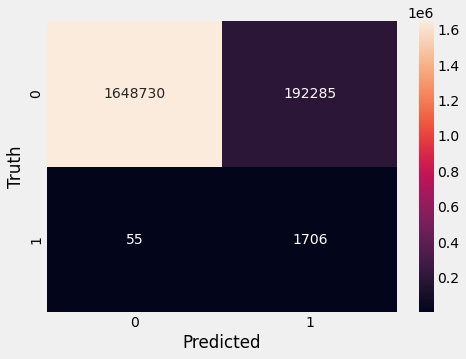

In [16]:
heatmap(xgb_model, y_test, X_test)

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Best Threshold=0.595887


c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


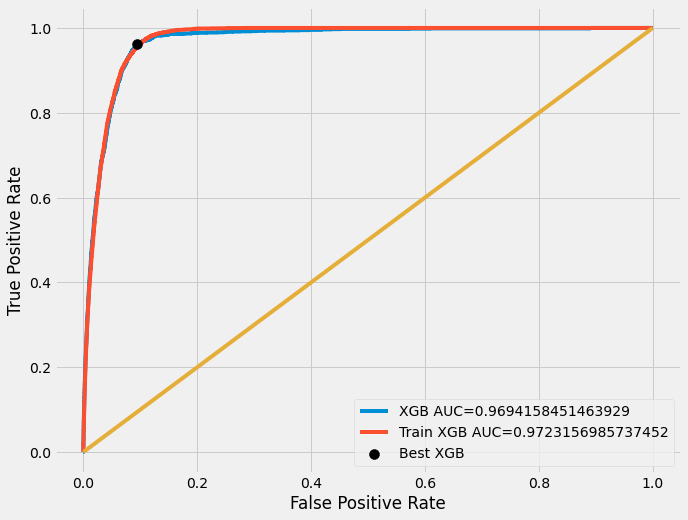

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

y_pred_proba2 = xgb_model.predict_proba(X_train)[::,1]
fpr2, tpr2, thresholds2 = roc_curve(y_train,  y_pred_proba2)
auc2 = roc_auc_score(y_train, y_pred_proba2)

# ROC
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label="XGB AUC="+str(auc))
plt.plot(fpr2, tpr2, label="Train XGB AUC="+str(auc2))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best XGB', s=100, zorder=3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot((0, 1), (0, 1))
plt.show()

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore')
kfold2 = StratifiedKFold(n_splits=5)
res = cross_val_score(xgb_model, X, y, cv=kfold2, scoring='roc_auc', fit_params={'eval_metric':'aucpr'})
print("średnia:", res.mean())
print('auc score:', res)

średnia: 0.9688482127015323
auc score: [0.96745969 0.96968592 0.9685022  0.96993378 0.96865947]


In [56]:
test_df = read_all_csv(data_path, data_type='test')

In [57]:
clean_test = clean_df(test_df, data_type='test')

In [58]:
clean_test = oh_encoding(clean_test)

In [59]:
preds = xgb_model.predict_proba(clean_test[cols])[::,1]

In [60]:
preds

array([5.2750704e-04, 7.1088499e-01, 6.1833760e-04, ..., 1.8855307e-02,
       4.9597193e-03, 3.7541782e-04], dtype=float32)

In [61]:
save = pd.DataFrame({'ticket_number': test_df['TICKET_NUMBER'], 'coupon_number': test_df['COUPON_NUMBER'], 'prediction': preds})

In [62]:
save.to_csv(data_path / 'KMO_TEAM_FCP_test_results_example9.csv', sep=';', index=False)

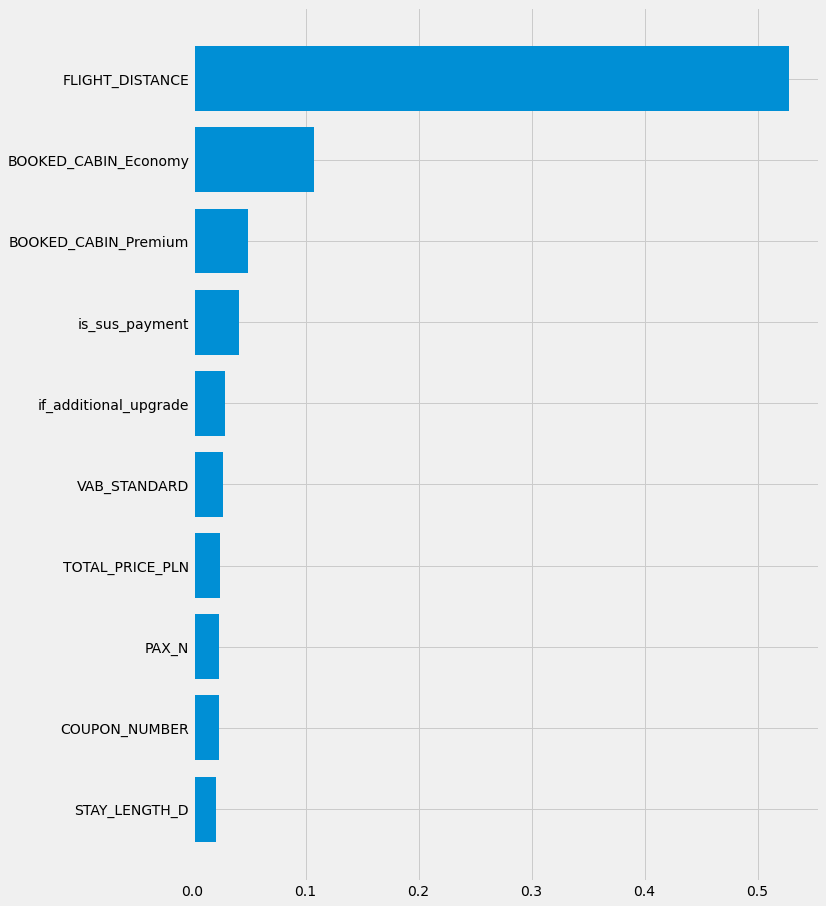

In [90]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(X_train.columns[sorted_idx][-10:], xgb_model.feature_importances_[sorted_idx][-10:])
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore')
xgb_model = xgb.XGBClassifier(**best_hypers,
                                  scale_pos_weight = 1046.6532651902328,
                                  seed=42,
                                  use_label_encoder=False, 
                                  tree_method="gpu_hist",
                                  gpu_id=0,)
kfold = StratifiedKFold(n_splits=5)
results = cross_val_score(xgb_model, X["FLIGHT_DISTANCE"], y, cv=kfold, scoring='roc_auc', fit_params={'eval_metric':'aucpr'})
print("średnia:", results.mean())
print('auc score:', results)

średnia: 0.9416910401933348
auc score: [0.93918548 0.94429779 0.94120479 0.942845   0.94092213]


In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore')
lista_kolumn = ['FLIGHT_DISTANCE', 'COUPON_NUMBER', 'TIME_DEPARTURE_LOCAL_TIME',
       'TOTAL_PRICE_PLN', 'CORPORATE_CONTRACT_FLG', 'BOOKING_WINDOW_D',
       'STAY_LENGTH_D', 'BOOKING_LONG_HOUL_FLAG', 'PAX_N',
       'sale_to_flight_time', 'flight_len', 'if_additional_upgrade',
       'same_carrier', 'is_sus_payment', 'intinerary_len', 'is_sus_currency',
       'FLIGHT_RANGE_LONG-HAUL', 'BOOKED_CABIN_Economy',
       'BOOKED_CABIN_Premium', 'VAB_OTHER', 'VAB_SAVER', 'VAB_STANDARD',
       'TRIP_TYPE_ROUND TRIP']
wszystkie_kolumny = X.columns.tolist()
x=0
while x<len(wszystkie_kolumny):
    if len(results) != 1 and results.mean() > prev_result:
        prev_result = results.mean()
    while wszystkie_kolumny[x] in lista_kolumn:
        x += 1
    else:
        lista_kolumn.append(wszystkie_kolumny[x])
    kolumny = X[lista_kolumn]
    xgb_model = xgb.XGBClassifier(**best_hypers,
                                  scale_pos_weight = 1046.6532651902328,
                                  seed=42,
                                  use_label_encoder=False, 
                                  tree_method="gpu_hist",
                                  gpu_id=0,)
    kfold = StratifiedKFold(n_splits=5)
    results = cross_val_score(xgb_model, kolumny, y, cv=kfold, scoring='roc_auc', fit_params={'eval_metric':'aucpr'})
    print("średnia:", results.mean())
    print('auc score:', results)
    print('kolumny:', kolumny.columns)
    if prev_result > results.mean():
        lista_kolumn.remove(wszystkie_kolumny[x])
    x += 1

średnia: 0.9751588444847201
auc score: [0.97437759 0.97489639 0.97370552 0.97759547 0.97521924]
kolumny: Index(['FLIGHT_DISTANCE', 'COUPON_NUMBER', 'TIME_DEPARTURE_LOCAL_TIME',
       'TOTAL_PRICE_PLN', 'CORPORATE_CONTRACT_FLG', 'BOOKING_WINDOW_D',
       'STAY_LENGTH_D', 'BOOKING_LONG_HOUL_FLAG', 'PAX_N',
       'sale_to_flight_time', 'flight_len', 'if_additional_upgrade',
       'same_carrier', 'is_sus_payment', 'intinerary_len', 'is_sus_currency',
       'FLIGHT_RANGE_LONG-HAUL', 'BOOKED_CABIN_Economy',
       'BOOKED_CABIN_Premium', 'VAB_OTHER', 'VAB_SAVER', 'VAB_STANDARD',
       'TRIP_TYPE_ROUND TRIP', 'PAX_GENDER'],
      dtype='object')
średnia: 0.9749741715469036
auc score: [0.97415735 0.97483206 0.97353089 0.97742439 0.97492617]
kolumny: Index(['FLIGHT_DISTANCE', 'COUPON_NUMBER', 'TIME_DEPARTURE_LOCAL_TIME',
       'TOTAL_PRICE_PLN', 'CORPORATE_CONTRACT_FLG', 'BOOKING_WINDOW_D',
       'STAY_LENGTH_D', 'BOOKING_LONG_HOUL_FLAG', 'PAX_N',
       'sale_to_flight_time', 'flight_l

średnia: 0.9751866812481695
auc score: [0.97436322 0.97490161 0.97387891 0.97754743 0.97524224]
kolumny: Index(['FLIGHT_DISTANCE', 'COUPON_NUMBER', 'TIME_DEPARTURE_LOCAL_TIME',
       'TOTAL_PRICE_PLN', 'CORPORATE_CONTRACT_FLG', 'BOOKING_WINDOW_D',
       'STAY_LENGTH_D', 'BOOKING_LONG_HOUL_FLAG', 'PAX_N',
       'sale_to_flight_time', 'flight_len', 'if_additional_upgrade',
       'same_carrier', 'is_sus_payment', 'intinerary_len', 'is_sus_currency',
       'FLIGHT_RANGE_LONG-HAUL', 'BOOKED_CABIN_Economy',
       'BOOKED_CABIN_Premium', 'VAB_OTHER', 'VAB_SAVER', 'VAB_STANDARD',
       'TRIP_TYPE_ROUND TRIP', 'BOOKING_DOMESTIC_FLAG', 'SALES_CHANNEL_DCS'],
      dtype='object')
średnia: 0.9751439605352676
auc score: [0.97442334 0.9748198  0.9736501  0.97777538 0.97505118]
kolumny: Index(['FLIGHT_DISTANCE', 'COUPON_NUMBER', 'TIME_DEPARTURE_LOCAL_TIME',
       'TOTAL_PRICE_PLN', 'CORPORATE_CONTRACT_FLG', 'BOOKING_WINDOW_D',
       'STAY_LENGTH_D', 'BOOKING_LONG_HOUL_FLAG', 'PAX_N',
       

IndexError: list index out of range

In [29]:
X_test.loc[5054156]

FLIGHT_DISTANCE              6955.000000
COUPON_NUMBER                   2.000000
TIME_DEPARTURE_LOCAL_TIME      16.000000
TOTAL_PRICE_PLN              2570.440000
CORPORATE_CONTRACT_FLG          0.000000
BOOKING_WINDOW_D               12.000000
STAY_LENGTH_D                  15.000000
BOOKING_LONG_HOUL_FLAG          1.000000
PAX_N                           4.000000
sale_to_flight_time            27.000000
flight_len                     21.833333
if_additional_upgrade           0.000000
same_carrier                    1.000000
is_sus_payment                  0.000000
intinerary_len                  3.000000
is_sus_currency                 0.000000
FLIGHT_RANGE_LONG-HAUL          1.000000
BOOKED_CABIN_Economy            1.000000
BOOKED_CABIN_Premium            0.000000
VAB_OTHER                       0.000000
VAB_SAVER                       0.000000
VAB_STANDARD                    0.000000
TRIP_TYPE_ROUND TRIP            1.000000
BOOKING_DOMESTIC_FLAG           0.000000
Name: 5054156, d

In [30]:
import dalex as dx
przyklad = X_test.loc[5054156]
xgb_exp = dx.Explainer(xgb_model, X_test, y_test, label='XGB Pipeline')

Preparation of a new explainer is initiated

  -> data              : 1842776 rows 24 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1842776 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB Pipeline
  -> predict function  : <function yhat_proba_default at 0x000002768C6A30D0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



  -> predicted values  : min = 1.2e-06, mean = 0.112, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.999, mean = -0.111, max = 1.0
  -> model_info        : package xgboost

A new explainer has been created!


In [31]:
bd_przyklad = xgb_exp.predict_parts(przyklad,
             type = 'break_down')
bd_przyklad.result

,variable_name,variable_value,variable,cumulative,contribution,sign,position,label
0,intercept,1,intercept,0.112337,0.112337,1.0,25,XGB Pipeline
1,FLIGHT_DISTANCE,6955.0,FLIGHT_DISTANCE = 6955.0,0.499920,0.387583,1.0,24,XGB Pipeline
2,TOTAL_PRICE_PLN,2570.0,TOTAL_PRICE_PLN = 2570.0,0.724664,0.224744,1.0,23,XGB Pipeline
3,TIME_DEPARTURE_LOCAL_TIME,16.0,TIME_DEPARTURE_LOCAL_TIME = 16.0,0.763601,0.038937,1.0,22,XGB Pipeline
4,intinerary_len,3.0,intinerary_len = 3.0,0.788912,0.025311,1.0,21,XGB Pipeline
5,BOOKED_CABIN_Economy,1.0,BOOKED_CABIN_Economy = 1.0,0.806897,0.017985,1.0,20,XGB Pipeline
6,VAB_SAVER,0.0,VAB_SAVER = 0.0,0.850161,0.043265,1.0,19,XGB Pipeline
7,sale_to_flight_time,27.0,sale_to_flight_time = 27.0,0.867691,0.017529,1.0,18,XGB Pipeline
8,BOOKING_WINDOW_D,12.0,BOOKING_WINDOW_D = 12.0,0.869696,0.002005,1.0,17,XGB Pipeline
9,VAB_OTHER,0.0,VAB_OTHER = 0.0,0.857500,-0.012195,-1.0,16,XGB Pipeline


In [32]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [33]:
bd_przyklad.plot(max_vars=30)
print('Prawdziwy wynik:', y_test.loc[5054156])

Prawdziwy wynik: 1


In [34]:
cp_przyklad = xgb_exp.predict_profile(przyklad[cols])
cp_przyklad.result

Calculating ceteris paribus:   0%|                                                                                                       | 0/24 [00:00<?, ?it/s]c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

c:\users\huber\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:262: Fut

,FLIGHT_DISTANCE,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,TOTAL_PRICE_PLN,CORPORATE_CONTRACT_FLG,BOOKING_WINDOW_D,STAY_LENGTH_D,BOOKING_LONG_HOUL_FLAG,PAX_N,sale_to_flight_time,flight_len,if_additional_upgrade,same_carrier,is_sus_payment,intinerary_len,is_sus_currency,FLIGHT_RANGE_LONG-HAUL,BOOKED_CABIN_Economy,BOOKED_CABIN_Premium,VAB_OTHER,VAB_SAVER,VAB_STANDARD,TRIP_TYPE_ROUND TRIP,BOOKING_DOMESTIC_FLAG,_original_,_yhat_,_vname_,_ids_,_label_
5054156,0.0,2.0,16.0,2570.44,0.0,12.0,15.0,1.0,4.0,27.0,21.833333,0.0,1.0,0.0,3.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,6955.0,0.000374,FLIGHT_DISTANCE,5054156,XGB Pipeline
5054156,122.4,2.0,16.0,2570.44,0.0,12.0,15.0,1.0,4.0,27.0,21.833333,0.0,1.0,0.0,3.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,6955.0,0.000374,FLIGHT_DISTANCE,5054156,XGB Pipeline
5054156,244.8,2.0,16.0,2570.44,0.0,12.0,15.0,1.0,4.0,27.0,21.833333,0.0,1.0,0.0,3.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,6955.0,0.000374,FLIGHT_DISTANCE,5054156,XGB Pipeline
5054156,367.2,2.0,16.0,2570.44,0.0,12.0,15.0,1.0,4.0,27.0,21.833333,0.0,1.0,0.0,3.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,6955.0,0.000374,FLIGHT_DISTANCE,5054156,XGB Pipeline
5054156,489.6,2.0,16.0,2570.44,0.0,12.0,15.0,1.0,4.0,27.0,21.833333,0.0,1.0,0.0,3.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,6955.0,0.021675,FLIGHT_DISTANCE,5054156,XGB Pipeline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054156,6955.0,2.0,16.0,2570.44,0.0,12.0,15.0,1.0,4.0,27.0,21.833333,0.0,1.0,0.0,3.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.96,0.0,0.839613,BOOKING_DOMESTIC_FLAG,5054156,XGB Pipeline
5054156,6955.0,2.0,16.0,2570.44,0.0,12.0,15.0,1.0,4.0,27.0,21.833333,0.0,1.0,0.0,3.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.97,0.0,0.839613,BOOKING_DOMESTIC_FLAG,5054156,XGB Pipeline
5054156,6955.0,2.0,16.0,2570.44,0.0,12.0,15.0,1.0,4.0,27.0,21.833333,0.0,1.0,0.0,3.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.98,0.0,0.839613,BOOKING_DOMESTIC_FLAG,5054156,XGB Pipeline
5054156,6955.0,2.0,16.0,2570.44,0.0,12.0,15.0,1.0,4.0,27.0,21.833333,0.0,1.0,0.0,3.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.99,0.0,0.839613,BOOKING_DOMESTIC_FLAG,5054156,XGB Pipeline


In [35]:
cp_przyklad.plot(variables=["same_carrier"])

In [192]:
sh_przyklad = xgb_exp.predict_parts(przyklad[cols],
             type = 'shap')
sh_przyklad.result

,variable,contribution,variable_name,variable_value,sign,label,B
0,BOOKING_WINDOW_D = 3.0,-0.004405,BOOKING_WINDOW_D,3.0,-1.0,XGB Pipeline,1
1,intinerary_len = 3.0,0.008224,intinerary_len,3.0,1.0,XGB Pipeline,1
2,sale_to_flight_time = 11.0,0.007879,sale_to_flight_time,11.0,1.0,XGB Pipeline,1
3,VAB_STANDARD = 0.0,-0.005789,VAB_STANDARD,0.0,-1.0,XGB Pipeline,1
4,FLIGHT_RANGE_LONG-HAUL = 1.0,0.000000,FLIGHT_RANGE_LONG-HAUL,1.0,0.0,XGB Pipeline,1
...,...,...,...,...,...,...,...
19,COUPON_NUMBER = 2.0,0.000439,COUPON_NUMBER,2.0,1.0,XGB Pipeline,0
20,BOOKING_LONG_HOUL_FLAG = 1.0,-0.000059,BOOKING_LONG_HOUL_FLAG,1.0,-1.0,XGB Pipeline,0
21,BOOKING_DOMESTIC_FLAG = 0.0,0.000000,BOOKING_DOMESTIC_FLAG,0.0,0.0,XGB Pipeline,0
22,is_sus_currency = 0.0,0.000000,is_sus_currency,0.0,0.0,XGB Pipeline,0


In [193]:
sh_przyklad.plot(max_vars=30)